In [317]:
import scispacy
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import zipfile
import os
import xmltodict
import json
import regex as re
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import nltk.data
#nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

##### Filetr by aticle type LT and AR

In [2]:
article_df = pd.read_hdf('data/nature/preprocessed/article_df.hdf')

In [3]:
article_df

,ArticleID,DOI,Issue,Volume,PageEnd,PageStart,PubYear,SortDate,Title,Type,Journal
0,048485a0,10.1038/048485a0,1247.0,48.0,508.0,485.0,1893,1893-09-21,The British Association,ed,Nature
1,048508a0,10.1038/048508a0,1247.0,48.0,509.0,508.0,1893,1893-09-21,The Thieving of Assyrian Antiquities\r\n,lt,Nature
2,048509a0,10.1038/048509a0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Bishop's Ring\r\n,lt,Nature
3,048509b0,10.1038/048509b0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Spring and Autumn of 1893\r\n,lt,Nature
4,048509c0,10.1038/048509c0,1247.0,48.0,512.0,509.0,1893,1893-09-21,Notes,misc,Nature
...,...,...,...,...,...,...,...,...,...,...,...
395498,149145b0,10.1038/149145b0,3770.0,149.0,146.0,145.0,1942,1942-01-31,NATIVE SUBSISTENCE ON THE AMERICAN CENTRAL PLAINS,nw,Nature
395499,149146a0,10.1038/149146a0,3770.0,149.0,146.0,146.0,1942,1942-01-31,EARTHQUAKE ORIGINS IN THE NEW ZEALAND REGION,nw,Nature
395500,149146b0,10.1038/149146b0,3770.0,149.0,146.0,146.0,1942,1942-01-31,FORTHCOMING EVENTS,misc,Nature
395501,149146c0,10.1038/149146c0,3770.0,149.0,146.0,146.0,1942,1942-01-31,APPOINTMENTS VACANT,misc,Nature


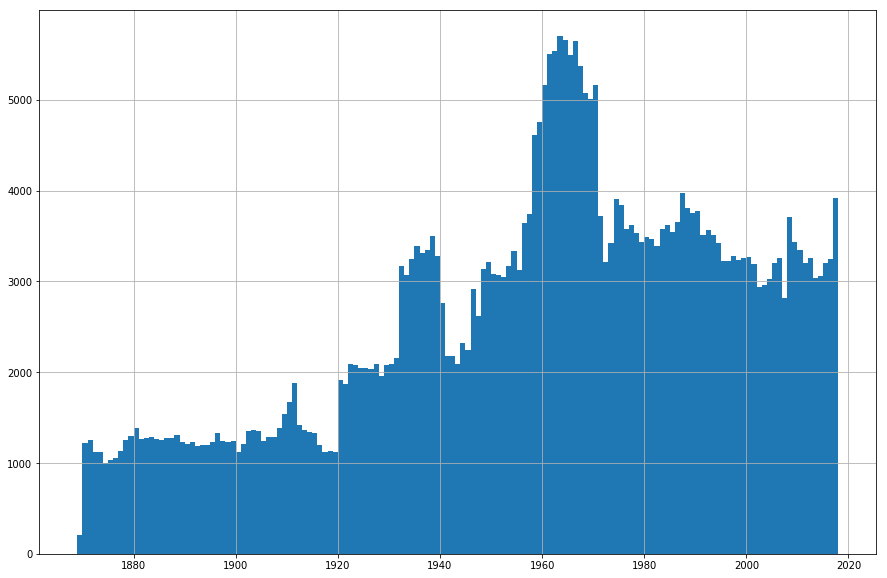

In [4]:
article_df['PubYear'].hist(bins = (article_df['PubYear'].max() - article_df['PubYear'].min()), figsize = (15, 10))

In [5]:
x = list(article_df[['ArticleID','PubYear']].groupby('PubYear').count()['ArticleID'])

In [57]:
w = np.fft.fft(x)
freqs = np.fft.fftfreq(len(w))

In [58]:
for coef,freq in zip(w,freqs):
    if coef:
        print('{c:>6} * exp(2 pi i t * {f})'.format(c=coef,f=freq))

(395503+0j) * exp(2 pi i t * 0.0)
(-47741.08173227605+108296.56565066085j) * exp(2 pi i t * 0.006666666666666667)
(-2916.647505104697-4446.201373113057j) * exp(2 pi i t * 0.013333333333333334)
(10539.743735805234+19397.577300762736j) * exp(2 pi i t * 0.02)
(-25020.935120043745+20768.783330945193j) * exp(2 pi i t * 0.02666666666666667)
(12143.577118135774-11115.604172927051j) * exp(2 pi i t * 0.03333333333333333)
(-7739.549818821184+29193.817441610612j) * exp(2 pi i t * 0.04)
(-11897.168711957263+2992.0775355719984j) * exp(2 pi i t * 0.04666666666666667)
(-2124.4129891429643+1883.9264314710495j) * exp(2 pi i t * 0.05333333333333334)
(-2058.8926500048374+8760.953164608516j) * exp(2 pi i t * 0.060000000000000005)
(-12443.556051734498-732.4449024497588j) * exp(2 pi i t * 0.06666666666666667)
(7775.474178371135+8722.553310698155j) * exp(2 pi i t * 0.07333333333333333)
(-10919.90605381349-3971.8651346329198j) * exp(2 pi i t * 0.08)
(-2641.354099406623+6462.622597416276j) * exp(2 pi i t * 0.0

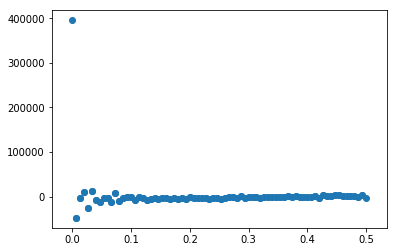

In [63]:
plt.scatter(abs(freqs), w)

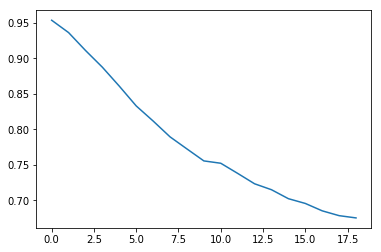

In [125]:
def autocorr(x, max_lag, steps):
    
    results = []
    
    for i in range(1, max_lag, steps):
        
        x_hat = np.append(np.zeros(i), x[:len(x)-i])
        results.append(np.corrcoef(x, x_hat)[1][0])
        
    return results

plt.plot(autocorr(x, 20, 1))

In [135]:
article_df.loc[0]

ArticleID                   048485a0
DOI                 10.1038/048485a0
Issue                           1247
Volume                            48
PageEnd                          508
PageStart                        485
PubYear                         1893
SortDate                  1893-09-21
Title        The British Association
Type                              ed
Journal                       Nature
Name: 0, dtype: object

In [145]:
with open('data/nature/preprocessed/abstract_df.pickle', 'rb') as f:
        abstract_df = pickle.load(f)

In [149]:
abstract_df

,ArticleID,Abstract
0,048485a0,THE Nottingham meeting of the British Associat...
1,048508a0,I HAD hoped that the British Museum slander ca...
2,048509a0,BISHOP'S RING still continues very conspicuous...
3,048509b0,As the peculiarities of this season are receiv...
4,048509c0,"MR. W. SAVILLE-KENT, at present engaged as Com..."
...,...,...
395498,149145b0,"IN a recent paper, W. R. Wedel dealt with man'..."
395499,149146a0,"R. C. HAYES, acting director of the Dominion O..."
395500,149146b0,(\nMeeting marked with an asterisk is open to ...
395501,149146c0,APPLICATIONS are invited for the following app...


In [159]:
directory = 'data/nature/raw xml/'
zfile = zipfile.ZipFile(os.path.join(directory, os.listdir(directory)[0]))

for finfo in zfile.infolist():
        ifile = zfile.open(finfo)
        line_list = ifile.readlines()

In [171]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [169]:
line_list[np.argmax(['4402' in str(line) for line in line_list])]

b'<iss>4402</iss>\r\n'

In [161]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [172]:
line_list

[b'<?xml version="1.0"?>\r\n',
 b'<!DOCTYPE headerx PUBLIC "-//NPG//DTD headerx//EN" "headerx.dtd">\r\n',
 b'<headerx>\r\n',
 b'<ArticleIdList>\r\n',
 b'<ArticleId>173508a0</ArticleId></ArticleIdList>\r\n',
 b'<pubfm>\r\n',
 b'<jtl>Nature</jtl>\r\n',
 b'<vol>173</vol>\r\n',
 b'<iss>4402</iss>\r\n',
 b'<idt>19540313</idt>\r\n',
 b'<categ id="categtxt"/>\r\n',
 b'<categtxt>Reports and other Publications</categtxt>\r\n',
 b'<pp><spn>508</spn><epn>508</epn></pp>\r\n',
 b'<issn>0028-0836</issn>\r\n',
 b'<cpg><cpy>1954</cpy><cpn>Nature Publishing Group</cpn></cpg>\r\n',
 b'<doi>10.1038/173508a0</doi>\r\n',
 b'</pubfm>\r\n',
 b'<fm>\r\n',
 b'<atl>Reports and other Publications</atl>\r\n',
 b'</fm>\r\n',
 b'<bdy>(not included in the monthly Books Supplement)\r\n',
 b'Great Britain and Ireland\r\n',
 b'Air Ministry : Meteorological Office. Averages of Temperature for Great Britain and Northern Ireland 1921-50. Pp. ii &plus; 36. (London : H.M. Stationery Office, 1953.) 2s. net. [121\r\n',
 b'Min

In [173]:
len(os.listdir(directory))

7867

In [190]:
os.listdir(directory)

['nature_v173_n4402_xml.zip',
 'nature_v18_n449_xml.zip',
 'nature_v260_n5554_xml.zip',
 'nature_v232_n5308_xml.zip',
 'nature_v485_n7400test-jo_xml.zip',
 'nature_v201_n4914_xml.zip',
 'nature_v57_n1476_xml.zip',
 'nature_v72_n1854_xml.zip',
 'nature_v57_n1468_xml.zip',
 'nature_v22_n554_xml.zip',
 'nature_v127_n3205_xml.zip',
 'nature_v78_n2034_xml.zip',
 'nature_v87_n2175_xml.zip',
 'nature_v12_n300_xml.zip',
 'nature_v110_n2772_xml.zip',
 'nature_v176_n4484_xml.zip',
 'nature_v43_n1121_xml.zip',
 'nature_v238_n5358_xml.zip',
 'nature_v258_n5531_xml.zip',
 'nature_v10_n237_xml.zip',
 'nature_v67_n1748_xml.zip',
 'nature_v158_n4018_xml.zip',
 'nature_v20_n501_xml.zip',
 'nature_v211_n5050_xml.zip',
 'nature_v369_n6478_xml.zip',
 'nature_v40_n1028_xml.zip',
 'nature_v373_n6512_xml.zip',
 'nature_v156_n3965_xml.zip',
 'nature_v88_n2202_xml.zip',
 'nature_v383_n6601_xml.zip',
 'nature_v104_n2611_xml.zip',
 'nature_v463_n7278_xml.zip',
 'nature_v39_n992_xml.zip',
 'nature_v109_n2738_xml.

In [234]:
directory = 'data/nature/raw xml/'
zfile = zipfile.ZipFile(os.path.join(directory, 'nature_v556_n7699_xml.zip'))

for finfo in zfile.infolist():
        ifile = zfile.open(finfo)
        print('\n')
        print(str(finfo))
        cont = ifile.read()
        print(xmltodict.parse(cont.decode('UTF-8')))



<ZipInfo filename='nature25029.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=107306 compress_size=27942>
OrderedDict([('article', OrderedDict([('@id', 'nature25029'), ('@language', 'eng'), ('@publish', 'issue'), ('@relation', 'no'), ('@origsrc', 'yes'), ('entity-declarations', OrderedDict([('entity', [OrderedDict([('@id', 'figf1'), ('@url', 'nature25029-f1.jpg')]), OrderedDict([('@id', 'figf2'), ('@url', 'nature25029-f2.jpg')]), OrderedDict([('@id', 'figf3'), ('@url', 'nature25029-f3.jpg')]), OrderedDict([('@id', 'figf4'), ('@url', 'nature25029-f4.jpg')]), OrderedDict([('@id', 'figs1'), ('@url', 'nature25029-sf1.jpg')]), OrderedDict([('@id', 'figs2'), ('@url', 'nature25029-sf2.jpg')]), OrderedDict([('@id', 'figs3'), ('@url', 'nature25029-sf3.jpg')]), OrderedDict([('@id', 'figs4'), ('@url', 'nature25029-sf4.jpg')]), OrderedDict([('@id', 'figs5'), ('@url', 'nature25029-sf5.jpg')]), OrderedDict([('@id', 'figs6'), ('@url', 'nature25029-sf6.jpg')]), OrderedDict([('@id', 'figs

OrderedDict([('article', OrderedDict([('@id', 'nature26152'), ('@language', 'eng'), ('@relation', 'no'), ('@origsrc', 'yes'), ('entity-declarations', OrderedDict([('entity', [OrderedDict([('@id', 'figf1'), ('@url', 'nature26152-f1.jpg')]), OrderedDict([('@id', 'figf2'), ('@url', 'nature26152-f2.jpg')]), OrderedDict([('@id', 'figf3'), ('@url', 'nature26152-f3.jpg')]), OrderedDict([('@id', 'figf4'), ('@url', 'nature26152-f4.jpg')]), OrderedDict([('@id', 'figs1'), ('@url', 'nature26152-sf1.jpg')]), OrderedDict([('@id', 'figs2'), ('@url', 'nature26152-sf2.jpg')]), OrderedDict([('@id', 'figs3'), ('@url', 'nature26152-sf3.jpg')]), OrderedDict([('@id', 'figs4'), ('@url', 'nature26152-sf4.jpg')]), OrderedDict([('@id', 'figs5'), ('@url', 'nature26152-sf5.jpg')]), OrderedDict([('@id', 'figs6'), ('@url', 'nature26152-sf6.jpg')]), OrderedDict([('@id', 'figs7'), ('@url', 'nature26152-sf7.jpg')]), OrderedDict([('@id', 'figs8'), ('@url', 'nature26152-sf8.jpg')]), OrderedDict([('@id', 'figs9'), ('@url

In [228]:
str(finfo)

"<ZipInfo filename='d41586-018-04053-z.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1634 compress_size=912>"

In [189]:
zfile.infolist()

[<ZipInfo filename='498410a.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=2267 compress_size=1242>,
 <ZipInfo filename='498410b.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1862 compress_size=1011>,
 <ZipInfo filename='498410c.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=2372 compress_size=1256>,
 <ZipInfo filename='498410d.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=2186 compress_size=1150>,
 <ZipInfo filename='498411a.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1990 compress_size=1063>,
 <ZipInfo filename='498411b.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=2284 compress_size=1258>,
 <ZipInfo filename='498411c.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1999 compress_size=1120>,
 <ZipInfo filename='498411d.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=2314 compress_size=1215>,
 <ZipInfo filename='498411e.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1977 comp

In [312]:
def get_reference_mapping(filename, content):
    
    """
    Given XML filename and XML file, extract rid mappings and attribute data
    """
    
    mappings  = {}
    extracted = {}
    references = {}
    parsed    = xmltodict.parse(content.decode('UTF-8'))
    soup      = BeautifulSoup(content)

    if '@id' in parsed['article']:
        extracted['id']       = parsed['article']['@id']
    if '@language' in parsed['article']:
        extracted['language'] = parsed['article']['@language']
    if '@publish' in parsed['article']:
        extracted['publish']  = parsed['article']['@publish']
    if '@relation' in parsed['article']:
        extracted['relation'] = parsed['article']['@relation']
    
    extracted['jtl']   = parsed['article']['pubfm']['jtl']
    extracted['vol']   = parsed['article']['pubfm']['vol']
    #extracted['issue'] = parsed['article']['pubfm']['issue']
    extracted['doi']   = parsed['article']['pubfm']['doi']

    for bib in soup.find_all("bib"):
        
        try:
            reference_attr = {}
            
            reference_attr['title']   = bib.atl.contents[0]
            reference_attr['snm']     = [i.contents[0] for i in bib.find_all('snm')]
            reference_attr['fnm']     = [i.contents[0] for i in bib.find_all('fnm')]
            reference_attr['journal'] = bib.jtl.contents[0]
            reference_attr['year']    = bib.find_all('cd')[0].contents[0]

            references.update({bib.attrs['id']: reference_attr})
        
        except Exception as e:
            
            print('='*50)
            print('Something is wrong with BeatifulSoup Tags: %s' % str(bib))
            for i in ['snm', 'fnm', 'journal', 'year', 'title']:
                if len(bib.find_all(i)) == 0:
                    print('%s attribute is missing.' %i)
            
            #raise Exception
            
    
    mappings = {'metadata': extracted, 'references': references}
    
    return mappings


def get_reference_text(filename, content):
    
    """
    Given XML filename and XML file, extract referencing text and reference metadata
    
    Returns  {str(unique_paper_indentifier), list(preceeding_text)}
    """
    
    content   = content.decode('UTF-8')
    bibid     = re.findall(r'<bibr\srid=\"(.*?)\"\/>', content)
    
    bibtext   = re.findall(r"\s.*?<bibr\s", content)
    
    assert(len(bibid) == len(bibtext)), "The bibid's and preceeding text don't match: " +\
                                        "for article %s\n" % filename +\
                                        "bibid: %s\n" %bibid +\
                                        "bibtext: %s\n" %bibtext
    
    return zip(bibid, bibtext), content
    
    #return content.decode('UTF-8')
    
def get_zips():
    
    """
    Function to extract relevant files from the filebase
    """
    
    citations = {}
    directory = 'data/nature/raw xml/'
    zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
    
    #zfile     = zipfile.ZipFile(os.path.join(directory, zip_list[0]))
    
    for zfile in tqdm(zip_list):
        
        zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

        for finfo in zfile.infolist():

            if 'nature' in finfo.filename:

                try:
                    ifile = zfile.open(finfo)
                    content = ifile.read()
                    tex_ref_map = get_reference_text(finfo.filename, content)
                    ref_id_ref_map = get_reference_mapping(finfo.filename, content)

                    citations[finfo.filename] = {'tex_ref_map': tex_ref_map,
                                                'ref_id_ref_map': ref_id_ref_map}
                except Exception as e:

                    print('Filename: %s, Content:%s, Zip:%s' % (finfo.filename,
                                                                content,
                                                                zfile))
                    raise Exception
            
    return citations
        
papers = get_zips()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b4">
<reftxt><refau><snm>Fuller</snm>, <fnm>M. T.</fnm></refau> in <btl>The Development of</btl> Drosophila Melanogaster (eds <refau><snm>Bate</snm>, <fnm>M.</fnm></refau> &amp; <refau><snm>Martinez-Arias</snm>, <fnm>A.</fnm></refau>) <ppf>71</ppf>–<ppl>147</ppl> (Cold Spring Harbor Laboratory Press, <cd year="1993">1993</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b20">
<reftxt><refau><snm>Dalgliesh</snm>, <fnm>G. L.</fnm></refau> <i>et al.</i> <atl>Systematic sequencing of renal carcinoma reveals inactivation of histone modifying genes</atl>. <jtl>Nature</jtl> <refdoi>10.1038/nature08672</refdoi> (in the press)</reftxt>
</

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b4">
<reftxt><refau><snm>Nagaosa</snm>, <fnm>N.</fnm></refau>, <refau><snm>Sinova</snm>, <fnm>J.</fnm></refau>, <refau><snm>Onoda</snm>, <fnm>S.</fnm></refau>, <refau><snm>MacDonald</snm>, <fnm>A.</fnm></refau> &amp; <refau><snm>Ong</snm>, <fnm>N. P.</fnm></refau> <atl>Anomalous Hall effect</atl>. <url>http://arxiv.org/abs/0904.4154</url> (<cd year="2009">2009</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b19">
<reftxt><refau><snm>Landau</snm>, <fnm>L. D.</fnm></refau> &amp; <refau><snm>Lifshitz</snm>, <fnm>E. M.</fnm></refau> <btl>Electrodynamics of Continuous Media</btl> 2nd edn (Elsevier, <cd year="1984">1984</cd>)</reftxt

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b32">
<reftxt><refau><snm>DeLano</snm>, <fnm>W. L.</fnm></refau> <atl>The PyMOL Molecular Graphics System</atl>. 〈<url>http://www.pymol.org</url>〉 (<cd year="2002">2002</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b40">
<reftxt><refau><snm>McRee</snm>, <fnm>D. E.</fnm></refau> <btl>Practical Protein Crystallography</btl> (Academic, San Diego, <cd year="1993">1993</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b30">


+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b98"><reftxt><refau><snm>Congdon</snm>, <fnm>K. L.</fnm></refau> <i>et al</i>. <atl>Activation of Wnt signaling in hematopoietic regeneration</atl>. <jtl>Stem Cells</jtl> doi:10.1634/stemcells.2007-0768 (in the press).</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b7"><reftxt>National Heart, Lung, and Blood Institute. <btl>Morbidity &amp; Mortality: 2002 Chart Book on Cardiovascular, Lung, and Blood Diseases</btl> (US Department of Health and Human Services, Bethesda, <cd year="2002">2002</cd>).</reftxt></bib>
snm attribute is missing.
fnm attribute is missing.
journal attribute is missing.
year attribute is missing.
title attribute

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b16">
<reftxt><refau><snm>Braginsky</snm>, <fnm>V. B.</fnm></refau> &amp; <refau><snm>Khalili</snm>, <fnm>F.</fnm></refau> <btl>Quantum Measurement</btl> <ppf>76</ppf>–<ppl>92</ppl> (Cambridge Univ. Press, <cd year="1992">1992</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b20">
<reftxt><refau><snm>Kogan</snm>, <fnm>S.</fnm></refau> <btl>Electronic Noise and Fluctuations in Solids</btl> <ppf>145</ppf>–<ppl>155</ppl> (Cambridge Univ. Press, <cd year="1996">1996</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b32">
<reftxt><refau><snm>Kutner</snm>, <fnm>M. H.</fnm></refau>, <refau><snm>Nachtsheim</snm>, <fnm>C. J.</fnm></refau>, <refau><snm>Neter</snm>, <fnm>J.</fnm></refau> &amp; <refau><snm>Li</snm>, <fnm>W.</fnm></refau> <btl>Applied Linear Statistical Models</btl> (McGraw-Hill/Irwin, <cd year="2005">2005</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b12">
<reftxt><refau><snm>Chesson</snm>, <fnm>P.</fnm></refau> in <btl>Unity in Diversity: Reflections on Ecology after the Legacy of Ramon Margalef</btl> (eds Valladares, F. <i>et al</i>.) <ppf>119</ppf>–<ppl>164</ppl> (Fundacion BBVA, <cd year="2008">2008</cd>)</reftxt>
</bib>
jo

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b2">
<reftxt><refau><snm>Maynard Smith</snm>, <fnm>J.</fnm></refau> <btl>Evolution and the Theory of Games</btl> (Cambridge Univ. Press, <cd year="1982">1982</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b7">
<reftxt><refau><snm>Sutton</snm>, <fnm>R. S.</fnm></refau> &amp; <refau><snm>Barto</snm>, <fnm>A. G.</fnm></refau> <btl>Reinforcement Learning: An Introduction</btl> (MIT Press, <cd year="1998">1998</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wron

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b2"><reftxt><refau><snm>McComb</snm>, <fnm>W. D.</fnm></refau> <btl>The Physics of Fluid Turbulence</btl> <ppf>2</ppf> (Clarendon, Oxford, <cd year="1990">1990</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b5"><reftxt><refau><snm>Kopnin</snm>, <fnm>N. B.</fnm></refau> <btl>Theory of Nonequilibrium Superconductivity</btl> <ppf>271</ppf> (Clarendon, Oxford, <cd year="2001">2001</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib 

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b15"><reftxt><refau><snm>Bernardi</snm>, <fnm>G.</fnm></refau>, (ed. Boyer, P. D.)) <btl>The Enzymes</btl>, <ppf>271</ppf>–<ppl>287</ppl> (Academic, New York, <cd year="1971">1971</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b25"><reftxt><refau><snm>Sambrook</snm>, <fnm>J.</fnm></refau> &amp; <refau><snm>Russell</snm>, <fnm>D. W.</fnm></refau> <btl>Molecular Cloning: A Laboratory Manual</btl> (Cold Spring Harbor Laboratory, Cold Spring Harbor, New York, <cd year="2001">2001</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b10"><reftxt><refau><snm>Sullivan</snm>, <fnm>M. B.</fnm></refau>, <refau><snm>Waterbury</snm>, <fnm>J. B.</fnm></refau> &amp; <refau><snm>Chisholm</snm>, <fnm>S. W.</fnm></refau> <atl>Cyanophages infecting the oceanic cyanobacterium <i>Prochlorococcus</i></atl>. <jtl>Nature</jtl> (in the press)</reftxt><natlink extrefid="00000"></natlink><!--nature01947--></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b13"><reftxt><refau><snm>Palenik</snm>, <fnm>B.</fnm></refau> <i>et al.</i> <atl>The genome of a motile marine <i>Synechococcus</i></atl>. <jtl>Nature</jtl> (this issue)</reftxt><natlink extrefid="00000"></natlink><!--nature01947--></bib>
jour

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b1">
<reftxt><refau><snm>Toffoli</snm>, <fnm>T.</fnm></refau> <btl>Reversible Computing</btl> (Lect. Notes Computer Sci. 85, Springer, <cd year="1980">1980</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b14">
<reftxt><refau><snm>Baur</snm>, <fnm>M.</fnm></refau> <i>et al.</i> <atl>Benchmarking a teleportation protocol realized in superconducting circuits</atl>. Preprint at 〈<url>http://arxiv.org/abs/1107.4774</url>〉 (<cd year="2011">2011</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b1"><reftxt><refau><snm>Van Valen</snm>, <fnm>L.</fnm></refau> <jtl>J. Herpetol.</jtl> <vid>8</vid>, <ppf>109</ppf>–<ppl>121</ppl> (<cd year="1974">1974</cd>).</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b2"><reftxt><refau><snm>Salazar-Ciudad</snm>, <fnm>I.</fnm></refau> &amp; <refau><snm>Marín-Riera</snm>, <fnm>M.</fnm></refau> <jtl>Nature</jtl> <vid>497</vid>, <ppf>361</ppf>–<ppl>364</ppl> (<cd year="2013">2013</cd>).</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is 

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b22">
<reftxt><refau><snm>Li</snm>, <fnm>B.</fnm></refau> <i>et al.</i> <atl>Down-regulation of miR-214 contributes to intrahepatic cholangiocarcinoma metastasis by targeting Twist. <i>FEBS</i> <i>J</i></atl>. <vid>279</vid>, <ppf>2393</ppf>–<ppl>2398</ppl> (<cd year="2012">2012</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b25">
<reftxt><refau><snm>Brox</snm>, <fnm>T.</fnm></refau>, <refau><snm>Bruhn</snm>, <fnm>A.</fnm></refau>, <refau><snm>Papenberg</snm>, <fnm>N.</fnm></refau> &amp; <refau><snm>Weickert</snm>, <fnm>J.</fnm></refau> High accuracy optical flow estimation based on a theory for warping. <btl>Lecture Notes in 

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b20">
<reftxt><refau><snm>Hipskind</snm>, <fnm>P. A.</fnm></refau>, <refau><snm>Patel</snm>, <fnm>B. K.</fnm></refau> &amp; <refau><snm>Wilson</snm>, <fnm>T.</fnm></refau> <atl>Disubstituted phthalazine hedgehog pathway antagonists. US patent 8,273,742 B2</atl>. (<cd year="2010">2010</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b24">
<reftxt><refau><snm>Ballesteros</snm>, <fnm>J. A.</fnm></refau> &amp; <refau><snm>Weinstein</snm>, <fnm>H.</fnm></refau> in <btl>Methods in Neurosciences</btl> Vol. 25 (ed. Sealfon, S. C.) <ppf>366</ppf>–<ppl>428</ppl> (Academic, <cd year="1995">1995</cd>)</reftxt>
</bib>
journal attribute is mi

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b18">
<reftxt><refau><snm>Smith</snm>, <fnm>J. M.</fnm></refau> &amp; <refau><snm>Szathmary</snm>, <fnm>E.</fnm></refau> <btl>The Major Transitions in Evolution</btl> (Oxford Univ.Press, <cd year="1995">1995</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b29">
<reftxt><refau><snm>Harold</snm>, <fnm>F. M.</fnm></refau> <btl>The Vital Force: A Study of Bioenergetics</btl> (Freeman, <cd year="1986">1986</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong wit

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b23">
<reftxt><refau><snm>Ronov</snm>, <fnm>A.</fnm></refau>, <refau><snm>Khain</snm>, <fnm>V.</fnm></refau> &amp; <refau><snm>Balukhovsky</snm>, <fnm>S.</fnm></refau> <btl>Atlas of Lithological-Paleogeographical Maps of the World: Mesozoic and Cenozoic of Continents and Oceans</btl> (eds <refau><snm>Barsukov</snm>, <fnm>V. L.</fnm></refau> &amp; <refau><snm>Laviorov</snm>, <fnm>N. P.</fnm></refau>) (Moscow Editorial Publishing Group VNII Zarubezh-Geologia, Moscow, <cd year="1989">1989</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b26">
<reftxt><refau><snm>Röhl</snm>, <fnm>U.</fnm></refau>, <refau><snm>Brinkhuis</snm>, <fnm>H

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b22">
<reftxt><refau><snm>BPS Database of RNA Base-pair Structures</snm></refau>. <url>http://bps.rutgers.edu/bps</url> (<cd year="2008">2008</cd>)</reftxt>
</bib>
fnm attribute is missing.
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b8">
<reftxt><refau><snm>Hong</snm>, <fnm>W.</fnm></refau>, <refau><snm>Mosca</snm>, <fnm>T. J.</fnm></refau> &amp; <refau><snm>Luo</snm>, <fnm>L.</fnm></refau> <atl>Teneurins instruct synaptic partner matching in an olfactory map</atl>. <jtl>Nature</jtl> <url>http://dx.doi.org/10.1038/nature10926</url> (this issue)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.


+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b28">
<reftxt><refau><snm>Nielsen</snm>, <fnm>M. A.</fnm></refau> &amp; <refau><snm>Chuang</snm>, <fnm>I. L.</fnm></refau> <btl>Quantum Computation and Quantum Information</btl> (Cambridge Univ. Press, <cd year="2000">2000</cd>)</reftxt>
</bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b1"><reftxt><refau><snm>Kerr</snm>, <fnm>R. A.</fnm></refau> <jtl>Science</jtl> <vid>288</vid>, <ppf>1984</ppf>–<ppl>1985</ppl> (<cd year="2000">2000</cd>).</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Someth

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b3"><reftxt><refau><snm>Deschamps</snm>, <fnm>J.-P</fnm></refau>., <refau><snm>Valderrama</snm>, <fnm>E</fnm></refau> &amp; <refau><snm>Terés</snm>, <fnm>L.</fnm></refau> <jtl>Design Methods</jtl> <ppf>171</ppf>–<ppl>177</ppl> (Springer, <cd year="2017">2017</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b5"><reftxt><refau><snm>Mosca</snm>, <fnm>M.</fnm></refau> in <jtl><i>Encyclopedia of Complexity and</i> Systems <i>Science</i></jtl> (ed. <refau><snm>Meyers</snm>, <fnm>R. A.</fnm></refau>) <ppf>7088</ppf>–<ppl>7118</ppl> (Springer, <cd year="2009">2009</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missi

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b8"><reftxt><refau><snm>Daemen</snm>, <fnm>J.</fnm></refau> &amp; <refau><snm>Rijmen</snm>, <fnm>V.</fnm></refau> <jtl>The Design of Rijndael: AES—The Advanced Encryption Standard</jtl> (Springer, <cd year="2002">2002</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b10"><reftxt><refau><snm>Rostovtsev</snm>, <fnm>A.</fnm></refau> &amp; <refau><snm>Stolbunov</snm>, <fnm>A.</fnm></refau> Public-key cryptosystem based on isogenies. Preprint at <weblink url="https://eprint.iacr.org/2006/145">https://eprint.iacr.org/2006/145</weblink> (<cd year="2006">2006</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
t

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b3"><reftxt><refau><snm>Le</snm>, <fnm>Q. V.</fnm></refau> <atl>Building high-level features using large scale unsupervised learning</atl>. In <btl>IEEE Int. Conf. on Acoustics, Speech and Signal Processing (ICASSP)</btl> <ppf>8595</ppf>–<ppl>8598</ppl> (IEEE, <cd year="2013">2013</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b5"><reftxt><refau><snm>Wittek</snm>, <fnm>P.</fnm></refau> <jtl>Quantum Machine Learning: What Quantum Computing Means to Data Mining</jtl> (Academic Press, New York, NY, USA, <cd year="2014">2014</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b53"><reftxt><refau><snm>Zheng</snm>, <fnm>S.</fnm></refau>, <refau><snm>Palovcak</snm>, <fnm>E.</fnm></refau>, <refau><snm>Armache</snm>, <fnm>J.-P.</fnm></refau>, <refau><snm>Cheng</snm>, <fnm>Y.</fnm></refau> &amp; <refau><snm>Agard</snm>, <fnm>D.</fnm></refau> Anisotropic correction of beam-induced motion for improved single-particle electron cryo-microscopy. Preprint at <newline></newline><weblink url="http://biorxiv.org/content/early/2016/07/04/061960">http://biorxiv.org/content/early/2016/07/04/061960</weblink> (<cd year="2016">2016</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b57"><reftxt><refau><snm>Bai</snm>, <fnm>X

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b41"><reftxt><refau><snm>Blakely</snm>, <fnm>R. J.</fnm></refau> <jtl>Potential Theory in Gravity and Magnetic Applications</jtl> (Cambridge Univ. Press, <cd year="1996">1996</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b25"><reftxt><refau><snm>Bailey</snm>, <fnm>N. T. J.</fnm></refau> <jtl>The Elements of Stochastic Processes with Applications to the Natural Sciences</jtl> (John Wiley &amp; Sons, <cd year="1990">1990</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Some

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b29"><reftxt>Google Earth Engine Team. <i>Google Earth Engine: A Planetary-Scale Geo-Spatial Analysis Platform</i> (<cd year="2017">2017</cd>)</reftxt></bib>
snm attribute is missing.
fnm attribute is missing.
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
Something is wrong with BeatifulSoup Tags: <bib id="b33"><reftxt><refau><snm>Lillesand</snm>, <fnm>T</fnm></refau>., <refau><snm>Kiefer</snm>, <fnm>R. W</fnm></refau> &amp; <refau><snm>Chipman</snm>, <fnm>J.</fnm></refau> <jtl>Remote Sensing and Image Interpretation</jtl> 7th Edn (John Wiley &amp; Sons, <cd year="2015">2015</cd>)</reftxt></bib>
journal attribute is missing.
year attribute is missing.
title attribute is missing.
+=+=+=+=+=+=+=+=+=+

Exception: 

In [292]:
papers

{'nature25029.xml': {'ref_id_ref_map': {'metadata': {'doi': '10.1038/nature25029',
    'id': 'nature25029',
    'jtl': 'Nature',
    'language': 'eng',
    'publish': 'issue',
    'relation': 'no',
    'vol': '556'},
   'references': {'b1': {'fnm': ['J. N.', 'R. A.'],
     'journal': 'Astrophys. J.',
     'snm': ['Bahcall', 'Wolf'],
     'title': 'Star distribution around a black hole in a globular cluster',
     'year': '1976'},
    'b10': {'fnm': ['M. J.'],
     'journal': 'Annu. Rev. Astron. Astrophys.',
     'snm': ['Reid'],
     'title': 'The distance to the center of the Galaxy',
     'year': '1993'},
    'b11': {'fnm': ['M. P.'],
     'journal': 'Astrophys. J. Suppl. Ser.',
     'snm': ['Muno'],
     'title': 'A catalog of X-ray point sources from two megaseconds of Chandra observations of the Galactic Center',
     'year': '2009'},
    'b12': {'fnm': ['R. A.', 'J. E.'],
     'journal': 'Annu. Rev. Astron. Astrophys.',
     'snm': ['Remillard', 'McClintock'],
     'title': 'X-ra

In [313]:
['\n</p><p>A storm of criticism has rained down on a paper by genome-sequencing pioneer Craig Venter that claims to predict people&#8217;s physical traits from their DNA. Reviewers and even a co-author of the paper say that it overstates the ability to use a person&#8217;s genes to identify the individual, which could raise unnecessary fears about genetic privacy.</p><p>In the paper<bibr ', ' />, published on 5 September in the&#160;<i>Proceedings of the National Academy of Sciences&#160;</i>(<i>PNAS</i>), Venter and colleagues at his company Human Longevity, Inc. (HLI), based in San Diego, California, sequenced the whole genomes of 1,061 people of varying ages and ethnic backgrounds. Using the genetic data, along with high-quality 3D photographs of the participants&#8217; faces, the researchers used an artificial intelligence approach to find small differences in DNA sequences, called SNPs, associated with facial features such as cheekbone height. The team also searched for SNPs that correlated with factors including a person&#8217;s height, weight, age, vocal characteristics and skin colour.</p><p>The approach correctly identified an individual out of a group of ten people randomly selected from HLI&#8217;s database 74% of the time. The findings, according to the paper, suggest that law-enforcement agencies, scientists and others who handle human genomes should protect the data carefully to prevent people from being identified by their DNA alone. &#8220;A core belief from the HLI researchers is that there is now no such thing as true deidentification and full privacy in publicly accessible databases,&#8221; HLI said in a statement.</p><crosshd>Contentious claim</crosshd><p>But other geneticists, having studied the paper, say that in their opinion, the claim is vastly overblown. &#8220;I don\'t think this paper raises those risks, because they haven&#8217;t demonstrated any ability to individuate this person from DNA,&#8221; says&#160;<weblink url="https://www.nature.com/news/mugshots-built-from-dna-data-1.14899">Mark Shriver</weblink>, an anthropologist at Pennsylvania State University in University Park. In a randomly selected group of ten people &#8212; especially one chosen from a data set as small and diverse as HLI&#8217;s &#8212; knowing age, sex and race alone rules out most of the individuals, he says.</p><p>To demonstrate this, computational biologist Yaniv Erlich of Columbia University in New York City looked at the age, sex and ethnicity data from HLI&#8217;s paper. In a study<bibr ', " /> published on&#160; September on the preprint server bioRxiv, he calculated that knowing only those three traits was sufficient to identify an individual out of a group of ten people in the HLI data set 75% of the time. Erlich contends that there was no need to know anything about the people&#8217;s genomes. Furthermore, he says, HLI&#8217;s reconstructions of facial structure from SNPs are not highly specific &#8212; they tend to look as much like an individual as anyone of that person&#8217;s sex and race.</p><p>Before it was published in <i>PNAS</i>, the paper had been submitted to <i>Science</i>, says Shriver who reviewed the paper for that journal. He says that HLI&#8217;s actual data are sound, and he is impressed with the group&#8217;s novel method of determining age by sequencing the ends of chromosomes, which shorten over time. But he says that the paper doesn&#8217;t demonstrate that individuals can be identified by their DNA, as it claims to. &#8220;I think it totally misrepresents what they did and what they found,&#8221; he says.</p><p>HLI said that its paper states that using multiple parameters, of which a person's face is only one, to identify someone is possible based on work with more than a thousand genomes. &#8220;It heralds that prediction will become increasingly precise,&#8221; says Heather Kowalski, an HLI spokesperson. HLI stated that it stands by its methodology and acknowledged that the sample set was small. The company published their response<bibr "]

['\n</p><p>A storm of criticism has rained down on a paper by genome-sequencing pioneer Craig Venter that claims to predict people&#8217;s physical traits from their DNA. Reviewers and even a co-author of the paper say that it overstates the ability to use a person&#8217;s genes to identify the individual, which could raise unnecessary fears about genetic privacy.</p><p>In the paper<bibr ',
 ' />, published on 5 September in the&#160;<i>Proceedings of the National Academy of Sciences&#160;</i>(<i>PNAS</i>), Venter and colleagues at his company Human Longevity, Inc. (HLI), based in San Diego, California, sequenced the whole genomes of 1,061 people of varying ages and ethnic backgrounds. Using the genetic data, along with high-quality 3D photographs of the participants&#8217; faces, the researchers used an artificial intelligence approach to find small differences in DNA sequences, called SNPs, associated with facial features such as cheekbone height. The team also searched for SNPs that